## Import Libraries

In [2]:
import torch
import torch
import torch.nn as nn

import transformers
from transformers import BertForSequenceClassification
from transformers import AutoModel, BertTokenizerFast

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import json

2023-06-07 18:29:19.317143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 18:29:20.108729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-07 18:29:20.108795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-07 18:29:20.108803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Loading our Trained Model

### Define the Default BERT Architecture

In [3]:
# Import the BERT-base pretrained model
BERT = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Define Custom BERT Architecture

In [4]:
class customBERTArchitecture(nn.Module):
    def __init__(self, bert):
        super(customBERTArchitecture, self).__init__()
        self.bert = bert 
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # ReLU activation function
        self.relu =  nn.ReLU()
        
        # Dense layer 1
        self.fullyConnected1 = nn.Linear(768, 512)     
        
        # Dense layer 2 (Output layer)
        self.fullyConnected2 = nn.Linear(512, 2)
        
        # Softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):
        # Pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        # Input layer
        x = self.fullyConnected1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fullyConnected2(x)
        
        # Apply softmax activation
        x = self.softmax(x)
        return x

## Define GPU Here if Available

In [5]:
deviceName = 'cpu'

In [6]:
device = torch.device(deviceName)

### Load the Weights of our Pre-trained Custom BERT Model

In [7]:
# Create an instance of the model
model = customBERTArchitecture(BERT)

# Load the saved weights
model.load_state_dict(torch.load('./assets/weights/weights.pt', map_location=torch.device(deviceName)))

# Set the model to evaluation mode
model.eval()

customBERTArchitecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

## Loading Pre-generated Tensors

### Define a Function to Read Tensor Data from a JSON file

In [8]:
def loadTensorsFromJSON(filePath):
    """
    Load PyTorch tensors from a JSON file.

    Args:
        file_path (str): Path to the JSON file to load from.

    Returns:
        A dictionary where the keys are the names of the tensors and the values are the PyTorch tensors loaded from the file.
    """
    with open(filePath, 'r') as f:
        toLoad = json.load(f)
        
    tensors = {}
    
    for name, variable in toLoad.items():
        tensors[name] = torch.tensor(variable)

    return tensors

In [9]:
tensors = loadTensorsFromJSON('./assets/tensors/tensors.json')
tensors

{'testSequenceTensor': tensor([[  101,  4067,  2017,  ...,     0,     0,     0],
         [  101,  6203,  5718,  ...,  2345,  3535,   102],
         [  101,  2073,  2024,  ...,     0,     0,     0],
         ...,
         [  101,  2053,  1012,  ...,  4309,  2489,   102],
         [  101,  1015,  1045,  ...,  1005,  1040,   102],
         [  101,  2524,  2444,  ..., 21472, 21472,   102]]),
 'testMaskTensor': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'testYTensor': tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0

### Saving the Tensors

In [10]:
testSequenceTensor = tensors['testSequenceTensor']
testMaskTensor = tensors['testMaskTensor']
testYTensor = tensors['testYTensor']
trainingLossTensor = tensors['trainingLossTensor']
validationLossTensor = tensors['validationLossTensor']
epochs = tensors['epochs']

## Using Trained Model to Predict

In [11]:
# Get predictions for test data
with torch.no_grad():
    preds = model(testSequenceTensor.to(device), testMaskTensor.to(device))
    preds = preds.detach().cpu().numpy()

## Check Model's Performance on Testing Data

In [12]:
# Model's performance
predications = np.argmax(preds, axis=1)
print(classification_report(testYTensor, predications))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       724
           1       0.90      0.96      0.93       112

    accuracy                           0.98       836
   macro avg       0.95      0.97      0.96       836
weighted avg       0.98      0.98      0.98       836



## Plotting Change in Training and Validation Losses

#### Convert lists to arrays

In [13]:
# Convert trainingLosses into a numpy array
trainingLosses = np.array(trainingLossTensor)

# Convert validationLosses into a numpy array
validationLosses = np.array(validationLossTensor)

#### Creating an x-axis

In [14]:
X = np.arange(0, epochs)

In [15]:
X.shape, trainingLosses.shape

((500,), (500,))

#### Plotting losses

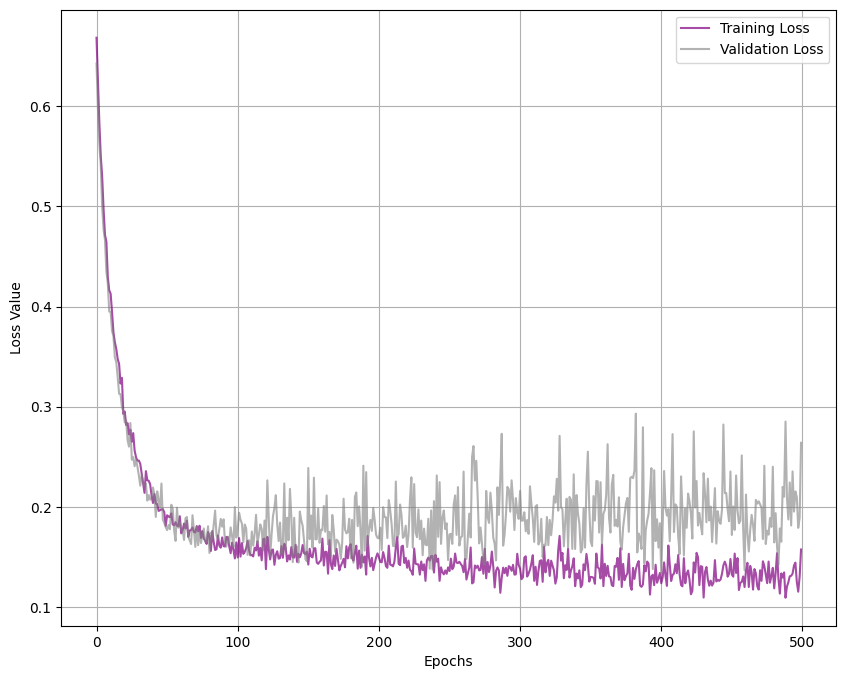

In [16]:
plt.figure(figsize=(10, 8))
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Loss Value")

plt.plot(X, trainingLosses, label='Training Loss', color='purple', alpha=0.7)
plt.plot(X, validationLosses, label='Validation Loss', color='gray', alpha=0.6)

plt.legend()
plt.show()

In [19]:
from torchview import draw_graph

In [20]:
batch_size = 16

In [21]:
draw_graph??

Signature:
draw_graph(
    model: 'nn.Module',
    input_data: 'INPUT_DATA_TYPE | None' = None,
    input_size: 'INPUT_SIZE_TYPE | None' = None,
    graph_name: 'str' = 'model',
    depth: 'int | float' = 3,
    device: 'torch.device | str | None' = None,
    dtypes: 'list[torch.dtype] | None' = None,
    mode: 'str | None' = None,
    strict: 'bool' = True,
    expand_nested: 'bool' = False,
    graph_dir: 'str | None' = None,
    hide_module_functions: 'bool' = True,
    hide_inner_tensors: 'bool' = True,
    roll: 'bool' = False,
    show_shapes: 'bool' = True,
    save_graph: 'bool' = False,
    filename: 'str | None' = None,
    directory: 'str' = '.',
    **kwargs: 'Any',
) -> 'ComputationGraph'
Source:   
def draw_graph(
    model: nn.Module,
    input_data: INPUT_DATA_TYPE | None = None,
    input_size: INPUT_SIZE_TYPE | None = None,
    graph_name: str = 'model',
    depth: int | float = 3,
    device: torch.device | str | None = None,
    dtypes: list[torch.dtype] | None = No

In [22]:
model_graph = draw_graph(model, device='meta')
model_graph.visual_graph

RuntimeError: Only one of (input_data, input_size) should be specified.

---